# How to use

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/simaki/epymetheus/blob/master/examples/howto/howto.ipynb)

In [1]:
# !pip install pandas matplotlib seaborn
# !pip install epymetheus

In [2]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
import seaborn
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
seaborn.set_style('ticks')

/usr/local/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import epymetheus
from epymetheus import Trade, Strategy

epymetheus?

Type:        module
String form: <module 'epymetheus' from '/usr/local/lib/python3.8/site-packages/epymetheus/__init__.py'>
File:        /usr/local/lib/python3.8/site-packages/epymetheus/__init__.py
Docstring:   <no docstring>


Let's construct your own strategy by subclassing `TradeStrategy`.

In [4]:
class SimpleTrendFollower(Strategy):
    """
    A simple trend-following strategy.
    Buy stocks for a month with the highest percentile of one month returns.
    Sell stocks for a month with the lowest percentile of one month returns.

    Parameters
    ----------
    - percentile : float
        The threshold to buy or sell.
        E.g. If 0.1, buy stocks with returns of highest 10%.
    - l_price : float
    - s_price : float
    - take
    - stop
    - hold
    """
    def __init__(self, percentile, l_price, s_price, take, stop, hold=DateOffset(months=3)):
        self.percentile = percentile
        self.l_price = l_price
        self.s_price = s_price
        self.take = take
        self.stop = stop
        self.hold = hold

    @staticmethod
    def sorted_assets(universe, open_date):
        """
        Return list of asset sorted according to one-month returns.
        Sort is ascending (poor-return first).

        Returns
        -------
        list
        """
        prices_now = universe.prices.loc[open_date]
        prices_bef = universe.prices.loc[open_date - DateOffset(months=1)]
        onemonth_returns = prices_now - prices_bef
        return list(onemonth_returns.sort_values().index)

    def logic(self, universe):
        n_trade = int(universe.n_assets * self.percentile)
        date_range = pd.date_range(universe.bars[0], universe.bars[-1], freq='BM')

        for open_date in date_range[1:]:
            assets = self.sorted_assets(universe, open_date)
            for asset_l, asset_s in zip(assets[-n_trade:][::-1], assets[:n_trade]):
                lot_l = +self.l_price / universe.prices.at[open_date, asset_l]
                lot_s = -self.s_price / universe.prices.at[open_date, asset_s]
                yield Trade(
                    asset=[asset_l, asset_s],
                    lot=[lot_l, lot_s],
                    open_bar=open_date,
                    shut_bar=open_date + self.hold,
                    take=self.take,
                    stop=self.stop,
                )

In [5]:
strategy = SimpleTrendFollower(
    percentile=0.2, l_price=10000, s_price=1000, take=1000, stop=-1000,
)

In [6]:
print(strategy.name)

SimpleTrendFollower


In [7]:
print(strategy.description)

A simple trend-following strategy.
Buy stocks for a month with the highest percentile of one month returns.
Sell stocks for a month with the lowest percentile of one month returns.

Parameters
----------
- percentile : float
    The threshold to buy or sell.
    E.g. If 0.1, buy stocks with returns of highest 10%.
- l_price : float
- s_price : float
- take
- stop
- hold


The strategy can be readily applied to any `Universe`.

In [8]:
from epymetheus.datasets import fetch_usstocks

universe = fetch_usstocks(n_assets=10)
universe.prices

,AAPL,MSFT,AMZN,BRK-A,JPM,JNJ,WMT,BAC,PG,XOM
2000-01-01,3.178732,37.349682,76.125000,56100,27.879496,27.661648,47.337238,14.720316,29.020367,22.445372
2000-01-02,3.178732,37.349682,76.125000,56100,27.879496,27.661648,47.337238,14.720316,29.020367,22.445372
2000-01-03,3.460857,37.289700,89.375000,54800,26.152460,27.346460,45.753605,14.207032,28.391300,21.818495
2000-01-04,3.169071,36.030037,81.937500,52000,25.651146,26.345306,44.041595,13.363776,27.844984,21.400583
2000-01-05,3.215448,36.409924,69.750000,53200,25.492819,26.623400,43.142776,13.510425,27.315243,22.567265
...,...,...,...,...,...,...,...,...,...,...
2019-12-27,288.333313,158.086731,1869.800049,338920,135.510101,143.829453,118.541725,34.882595,124.515007,67.590294
2019-12-28,288.333313,158.086731,1869.800049,338920,135.510101,143.829453,118.541725,34.882595,124.515007,67.590294
2019-12-29,288.333313,158.086731,1869.800049,338920,135.510101,143.829453,118.541725,34.882595,124.515007,67.590294
2019-12-30,290.044617,156.724243,1846.890015,338750,135.013397,143.385391,118.353401,34.685246,122.915245,67.193794


In [9]:
strategy.run(universe)

Running ... 
Generating 478 trades (2019-12-31 00:00:00) ... Done. (Runtime : 0.29 sec)
Executing 478 trades ... Done. (Runtime : 0.42 sec)
Done. (Runtime : 0.71 sec)


Now the result is stored as the attributes of `strategy`.

You can plot the wealth right away:

In [10]:
df_wealth = strategy.wealth.to_dataframe()
df_wealth[-5:]

,wealth
bars,
2019-12-27,96948.309285
2019-12-28,96948.309285
2019-12-29,96948.309285
2019-12-30,96716.468151
2019-12-31,96771.221681


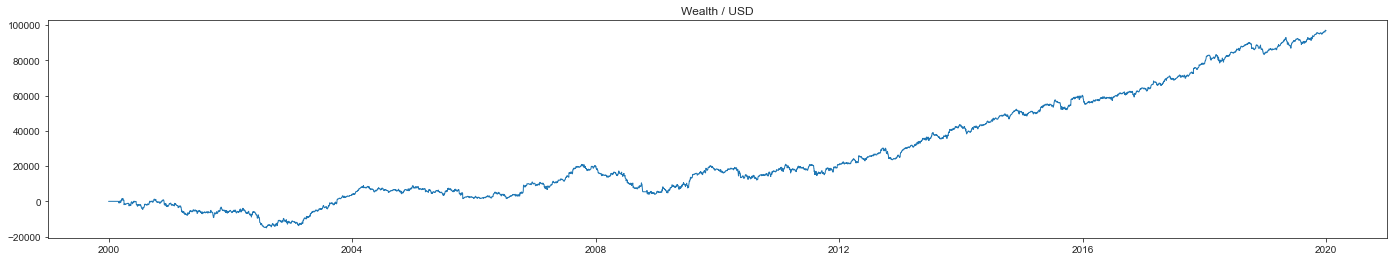

In [11]:
plt.figure(figsize=(24, 4))
plt.plot(df_wealth, linewidth=1)
plt.title('Wealth / USD')

plt.savefig('wealth.png', bbox_inches="tight", pad_inches=0.1)
plt.show()

You can also inspect the exposure as:

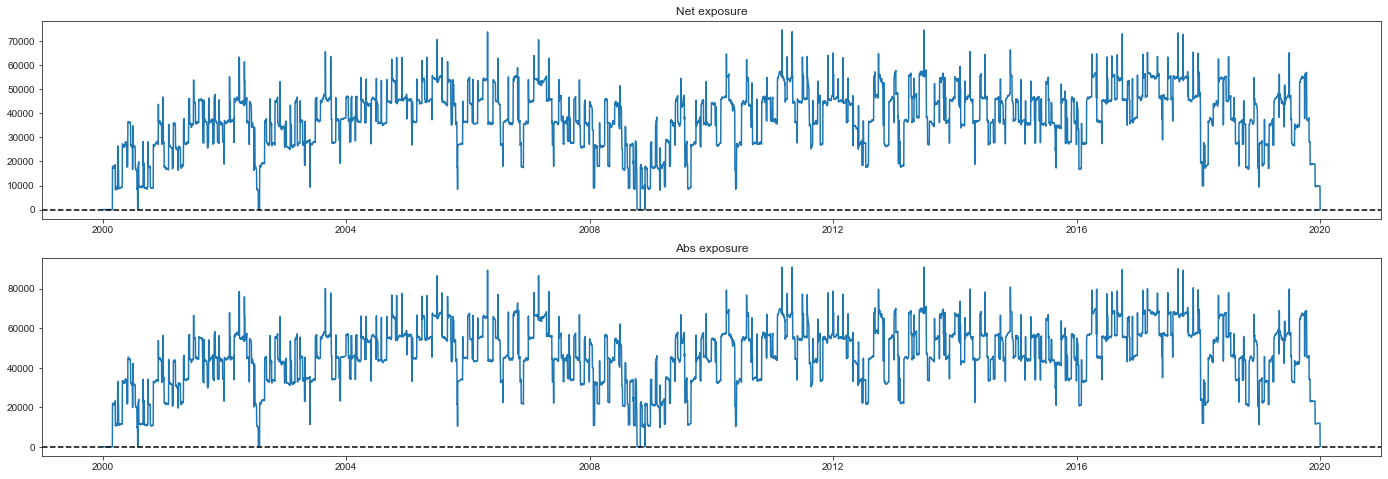

In [12]:
from epymetheus.metrics import Exposure

net_exposure = strategy.evaluate(Exposure())
abs_exposure = strategy.evaluate(Exposure(net=False))

series_net_exposure = pd.Series(net_exposure, index=strategy.universe.bars)
series_abs_exposure = pd.Series(abs_exposure, index=strategy.universe.bars)

plt.figure(figsize=(24, 8))
plt.subplot(2,1,1)
plt.plot(series_net_exposure)
plt.axhline(0, ls='--', color='k')
plt.title('Net exposure')
plt.subplot(2,1,2)
plt.plot(series_abs_exposure)
plt.axhline(0, ls='--', color='k')
plt.title('Abs exposure')

plt.savefig('exposure.png', bbox_inches="tight", pad_inches=0.1)
plt.show()

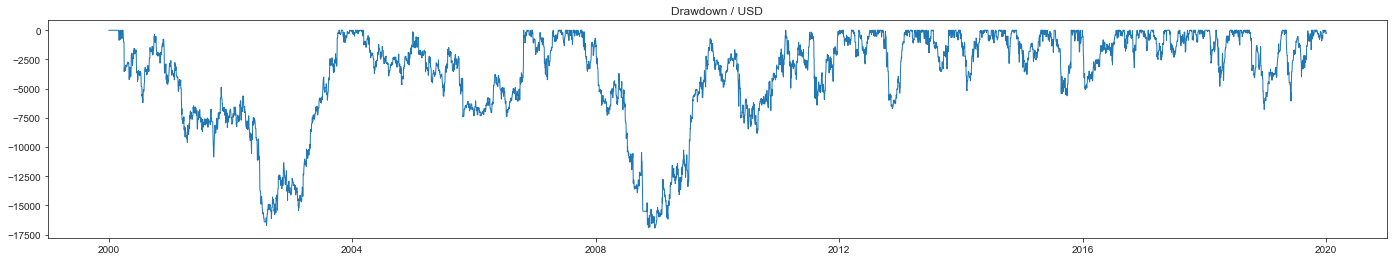

In [13]:
from epymetheus.metrics import Drawdown, MaxDrawdown, SharpeRatio

drawdown = strategy.evaluate(Drawdown())
series_drawdown = pd.Series(drawdown, index=strategy.universe.bars)

plt.figure(figsize=(24, 4))
plt.plot(series_drawdown, linewidth=1)
plt.title('Drawdown / USD')

plt.savefig('drawdown.png', bbox_inches="tight", pad_inches=0.1)
plt.show()

In [14]:
max_drawdown = strategy.evaluate(MaxDrawdown())
print(max_drawdown)

-235.1600310171052


In [15]:
sharpe_ratio = strategy.evaluate(SharpeRatio())
print(sharpe_ratio)

0.03908739015050315


Profit-loss distribution can be accessed by:

In [16]:
df_history = strategy.history.to_dataframe()
df_history

,trade_id,asset,lot,open_bar,close_bar,shut_bar,take,stop,pnl
order_id,,,,,,,,,
0,0,AMZN,145.190563,2000-02-29,2000-04-05,2000-05-29,1000,-1000,-970.961887
1,0,BRK-A,-0.022727,2000-02-29,2000-04-05,2000-05-29,1000,-1000,-288.636364
2,1,JPM,347.005748,2000-02-29,2000-03-16,2000-05-29,1000,-1000,1318.682468
3,1,WMT,-29.954210,2000-02-29,2000-03-16,2000-05-29,1000,-1000,-121.923224
4,2,BRK-A,0.174825,2000-03-31,2000-06-30,2000-06-30,1000,-1000,-594.405594
...,...,...,...,...,...,...,...,...,...
951,475,XOM,-15.177223,2019-11-29,2020-02-29,2020-02-29,1000,-1000,0.000000
952,476,BRK-A,0.029447,2019-12-31,2020-03-31,2020-03-31,1000,-1000,0.000000
953,476,WMT,-8.489087,2019-12-31,2020-03-31,2020-03-31,1000,-1000,0.000000


Profit-loss distribution

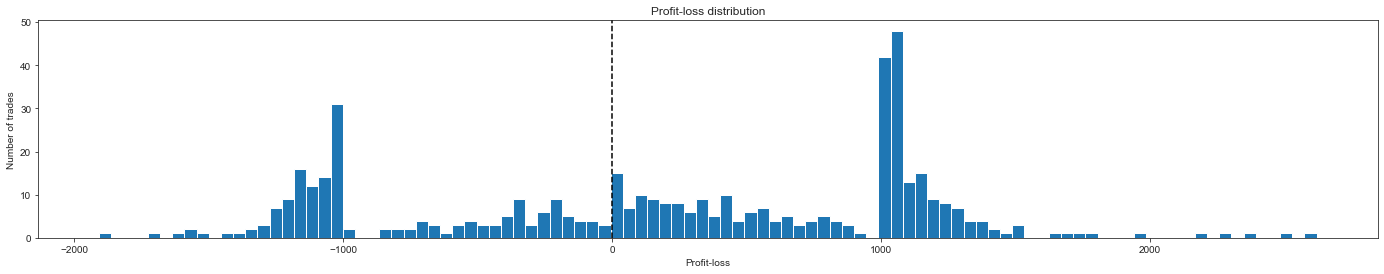

In [17]:
pnls = df_history.groupby('trade_id').aggregate('sum').pnl

plt.figure(figsize=(24, 4))
plt.hist(pnls, bins=100)
plt.axvline(0, ls='--', color='k')
plt.title('Profit-loss distribution')
plt.xlabel('Profit-loss')
plt.ylabel('Number of trades')

plt.savefig('pnl.png', bbox_inches="tight", pad_inches=0.1)
plt.show()

Detailed trade history can be viewed as:

In [18]:
df_history = strategy.history.to_dataframe()

with open('history.md', 'w') as f:
    f.write(df_history.head().to_markdown())
    
df_history.head()

,trade_id,asset,lot,open_bar,close_bar,shut_bar,take,stop,pnl
order_id,,,,,,,,,
0,0,AMZN,145.190563,2000-02-29,2000-04-05,2000-05-29,1000,-1000,-970.961887
1,0,BRK-A,-0.022727,2000-02-29,2000-04-05,2000-05-29,1000,-1000,-288.636364
2,1,JPM,347.005748,2000-02-29,2000-03-16,2000-05-29,1000,-1000,1318.682468
3,1,WMT,-29.954210,2000-02-29,2000-03-16,2000-05-29,1000,-1000,-121.923224
4,2,BRK-A,0.174825,2000-03-31,2000-06-30,2000-06-30,1000,-1000,-594.405594
